### This notebook uses some new library functions in the a405dropgrow package to find equilibrium drop sizes

In [28]:
import a405dropgrow.aerolib
from importlib import reload
reload(a405dropgrow.aerolib)
#
# new library for aerosol functions
#
from a405dropgrow.aerolib import lognormal,create_koehler,find_koehler_coeffs
import numpy as np
import a405utils.helper_funs
reload(a405utils.helper_funs)
from a405utils.helper_funs import make_tuple, find_centers
from a405thermo.rootfinder import find_interval, fzero
import ruamel.yaml as ry  #need to pip install ruamel.yaml
import pandas as pd
#
# load pprint to print the yaml input
#
import pprint
pp = pprint.PrettyPrinter(indent=4)
#
# find the path to the data folder.  We know it's
# at the same level as a405utils, so construct
# the path relative to the location of the a405utils folder
#
from pathlib import Path
util_dir = a405utils.__path__[0]
#print(util_dir)
data_dir = Path(util_dir).joinpath('../data')

### Read in the inital conditions from a yaml file

Use the [yaml](https://en.wikipedia.org/wiki/YAML) file format to specify
aerosol properties and initial conditions as a nested dictionary with
comments

In [29]:
yaml_file = data_dir.joinpath('dropgrow.yaml')
with yaml_file.open('r') as f:
    input_dict=ry.load(f,Loader=ry.RoundTripLoader)
pp.pprint(input_dict)

CommentedOrderedMap([   ('output_file', 'outfile.h5'),
                        ('frame_name', 'dump_run'),
                        ('dump_output', True),
                        (   'initial_conditions',
                            CommentedOrderedMap([   ('Tinit', 280.0),
                                                    ('Zinit', 1000.0),
                                                    ('Pinit', 90000.0),
                                                    ('Sinit', 0.995),
                                                    ('wvel', 0.5)])),
                        (   'aerosol',
                            CommentedOrderedMap([   ('Ms', 114),
                                                    ('Mw', 18.0),
                                                    ('Sigma', 0.075),
                                                    ('vanHoff', 2.0),
                                                    ('rhoaero', 1775),
                                                    ('themean'

### Calculate the lognormal aerosol mass distribution and get the number concentration in each of 30 bins

(code borrowed from aero.ipynb)

In [30]:
mass_vals = np.linspace(-20,-16,30)
mass_vals = 10**mass_vals
mu=input_dict['aerosol']['themean']
sigma = input_dict['aerosol']['sd']
totmass = input_dict['aerosol']['totmass']
mdist = totmass*lognormal(mass_vals,np.log(mu),np.log(sigma))
mdist = find_centers(mdist)*np.diff(mass_vals)
center_mass = find_centers(mass_vals)
ndist = mdist/center_mass

### Find the equilibrium radius for each of the 30 aerosol masses

(code borrowed from koehler.ipynb)

### Python note -- using function factories ("closures")

A closure is a function object that remembers values in its  "enclosing scope" 
(see e.g [this article](http://www.shutupandship.com/2012/01/python-closures-explained.html)).  For example, instead of
writing:

```python
my_string = "{:8.3g}".format(value)
```
    
every time we wanted to format a floating point number, we could do something like this:

In [31]:
def make_format(format_string="{:8.3g}"):
    """
    returns a function that formats with format_string
    """
    def inner_fun(value):
        return format_string.format(value)
    return inner_fun

#Now get closures from make_format and use it:

g = make_format()
info = make_format(format_string="debugging {}")

a=10
b=1.546e-23
print(info(a), g(b))


debugging 10 1.55e-23


### Calculating the equilibrium size distribution for unactivated aerosols

Below we use the rootfinder to search on log(radius) to find the equilibrium
drop size for unactivaed aerosols on the left side of their Koehler curves

In [32]:
aero=make_tuple(input_dict['aerosol'])
parcel=make_tuple(input_dict['initial_conditions'])

a, b = find_koehler_coeffs(aero,parcel)

#
# sanity check
#
m=1.e-18
Scrit=(4.*a**3./(27.*b*m))**0.5;
rcrit = (3.*m*b/a)**0.5
print(("for aerosol with mass = {} kg, "
       "SScrit,rcrit are {:8.3g}, {:8.3g} microns")
        .format(m,Scrit,rcrit*1.e6))


for aerosol with mass = 1e-18 kg, SScrit,rcrit are  0.00175,    0.441 microns


In [33]:
koehler_fun = create_koehler(aero,parcel)

def find_diff(logr,S_target,m):
    """
    zero function for rootfinder
    """
    r = np.exp(logr)
    return S_target - koehler_fun(r,m)

S_target = parcel.Sinit
S_target = 0.50
logr_start = np.log(0.1e-6)

initial_radius = []
for mass in center_mass:
    brackets = np.array(find_interval(find_diff,logr_start,S_target,mass))
    left_bracket, right_bracket = np.exp(brackets)*1.e6  #get brackets in microns for printing
    equil_rad = np.exp(fzero(find_diff,brackets,S_target,mass))
    
    Scrit=(4.*a**3./(27.*b*mass))**0.5
    
    initial_radius.append(equil_rad)
    print(('mass = {mass:6.3g} kg\n'
           'left bracket = {left_bracket:8.3e} microns\n'
           'right bracket={right_bracket:8.3e} microns\n'
           'critical supersaturation: {Scrit:6.3g}')
           .format_map(locals()))
    print('equlibrium radius at S={} is {:5.3f} microns\n'.format(S_target,equil_rad*1.e6))
   


mass = 1.19e-20 kg
left bracket = 1.318e+00 microns
right bracket=7.586e-03 microns
critical supersaturation: 0.0161
equlibrium radius at S=0.5 is 0.009 microns

mass = 1.63e-20 kg
left bracket = 1.318e+00 microns
right bracket=7.586e-03 microns
critical supersaturation: 0.0137
equlibrium radius at S=0.5 is 0.010 microns

mass = 2.24e-20 kg
left bracket = 1.318e+00 microns
right bracket=7.586e-03 microns
critical supersaturation: 0.0117
equlibrium radius at S=0.5 is 0.011 microns

mass = 3.08e-20 kg
left bracket = 1.318e+00 microns
right bracket=7.586e-03 microns
critical supersaturation: 0.00999
equlibrium radius at S=0.5 is 0.012 microns

mass = 4.23e-20 kg
left bracket = 1.318e+00 microns
right bracket=7.586e-03 microns
critical supersaturation: 0.00853
equlibrium radius at S=0.5 is 0.014 microns

mass = 5.81e-20 kg
left bracket = 1.318e+00 microns
right bracket=7.586e-03 microns
critical supersaturation: 0.00727
equlibrium radius at S=0.5 is 0.016 microns

mass = 7.98e-20 kg
left b

In [34]:
from a405thermo.constants import constants as c
import matplotlib.pyplot as plt

def find_vols(aerosol_mass,drop_radius):
    aero_vol = aerosol_mass/aero.rhoaero
    drop_vol = 4./3.*np.pi*drop_radius**3.
    water_vol = drop_vol - aero_vol
    return (aero_vol,water_vol)

def find_ratios(aerosol_mass,aero_vol,water_vol):
    total_vol = water_vol + aero_vol
    ns = aerosol_mass/aero.Mw
    nw_exact = water_vol*c.rhol/aero.Mw
    nw_approx = total_vol*c.rhol/aero.Mw
    return (ns/nw_approx, ns/nw_exact)
    
paired_vals = zip(center_mass,initial_radius) 
ratios = []
for mass,radius in paired_vals:
    aero_vol, water_vol = find_vols(mass,radius)
    approx_ratio,exact_ratio = find_ratios(mass,aero_vol,water_vol)
    ratios.append((approx_ratio,exact_ratio))
df_out = pd.DataFrame.from_records(ratios,columns=['approx','exact'])

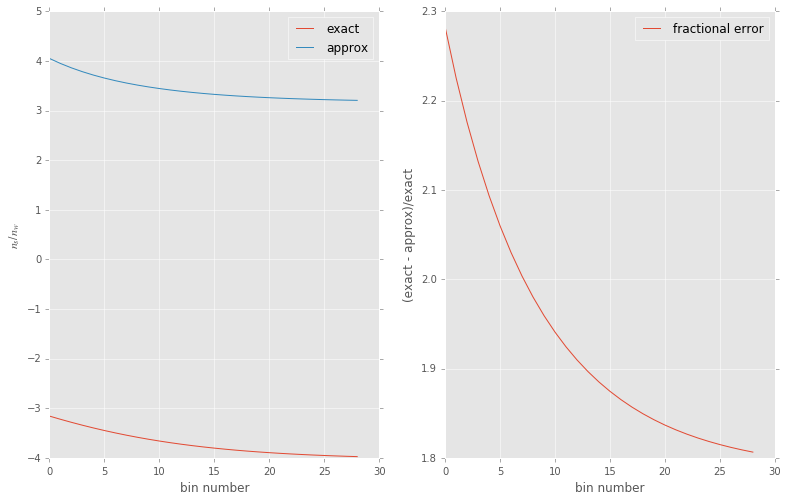

In [35]:
%matplotlib inline
plt.close('all')
plt.style.use('ggplot')
fig, ax = plt.subplots(1,2,figsize=(13,8))
ax[0].plot('exact',label='exact',data=df_out)
ax[0].plot('approx',label='approx',data=df_out)
ax[0].legend()
ax[1].plot((df_out['exact'] - df_out['approx'])/df_out['exact'],label='fractional error')
ax[1].legend()
ax[0].set(xlabel='bin number',ylabel='$n_s/n_w$')
out=ax[1].set(xlabel='bin number',ylabel='(exact - approx)/exact')